In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

In [2]:
def image(a1, a2, s):
    fig, ax = plt.subplots()
    ax.plot(a1, a2, '-', color = 'darkblue')
    ax.set_title(s)
    ax.grid()
    plt.show()

$
\frac{dx}{dt} = u\\
\frac{du}{dt} = x + 2v - \eta \left({\frac{x + \mu}A}\right) - \mu \left({\frac{x - \eta}B}\right)\\
\frac{dy}{dt} = v\\
\frac{dv}{dt} = y - 2u - \eta \left({\frac yA}\right) - \mu \left({\frac yB}\right)
$

### По схеме Эйлера

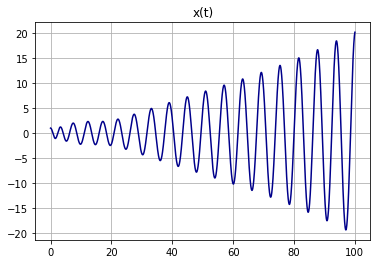

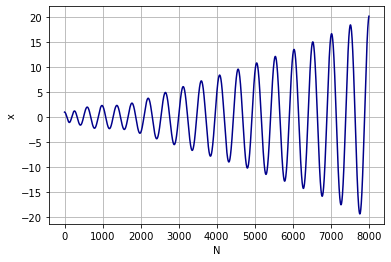

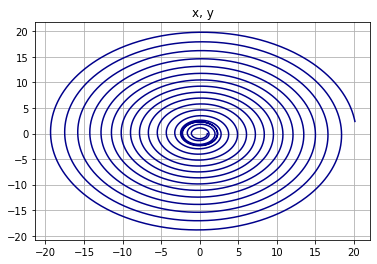

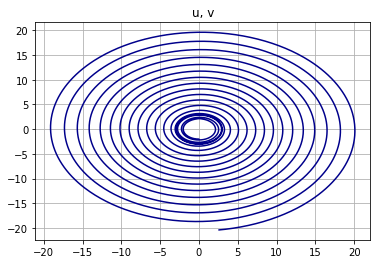

In [10]:
class data:
    def __init__(self, x, y, u, v):
        self.x, self.y, self.u, self.v = x, y, u, v

class solver:
    def __init__(self, eta, mu, d):
        self.eta, self.mu = eta, mu
        self.T = 100
        self.N = int(8e+3)
        self.h = self.T / self.N
        self.d = d
        
    def A_(self):
        x, y = self.d.x, self.d.y
        mu = self.mu
        
        return ((x + mu)**2 + y**2)**(3/2)

    def B_(self):
        x, y = self.d.x, self.d.y
        eta = self.eta
        
        return ((x - eta)**2 + y**2)**(3/2)

    def x_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        
        return x + u * h

    def u_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        eta, mu = self.eta, self.mu
        A = self.A_()
        B = self.B_()
        
        u_f = (x + 2 * v) - eta * ((x + mu) / A) - mu * ((x - eta) / B)
        return u + u_f * self.h

    def y_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        
        return y + v * h

    def v_iter(self):
        x, y, u, v = self.d.x, self.d.y, self.d.u, self.d.v
        h = self.h
        eta, mu = self.eta, self.mu
        A = self.A_()
        B = self.B_()
        
        v_f = (y - 2 * u) - eta * (y / A) - mu * (y / B)
        return v + v_f * h
    
    def solve_(self):
        self.arr = []
        for i in range(self.N):
            x = self.x_iter()
            y = self.y_iter()
            u = self.u_iter()
            v = self.v_iter()
            self.d = data(x, y, u, v)
            self.arr.append(self.d)
        
    def image(self):
        arr_x, arr_y, arr_u, arr_v = [], [], [], []
        for i in range(self.N):
            arr_x.append(self.arr[i].x)
            arr_y.append(self.arr[i].y)
            arr_u.append(self.arr[i].u)
            arr_v.append(self.arr[i].v)

        arr_t = np.linspace(0, self.T, self.N)

        image(arr_t, arr_x, 'x(t)')
        plt.plot(np.arange(self.N), arr_x, color = 'darkblue')
        plt.xlabel('N')
        plt.ylabel('x')
        plt.grid()
        
        image(arr_x, arr_y, 'x, y')
        image(arr_u, arr_v, 'u, v')
        
    def solve(self):
        self.solve_()
        self.image()

mu = 0.012277471
eta = 1 - mu

x, y, u, v = 0.994, 0, 0, -2.00158510637908252240537862224
d = data(x, y, u, v)

S = solver(mu, eta, d)
S.solve()

### По методу Дормана-Принса

In [11]:
mu = 0.012277471
eta = 1 - mu

A = lambda x, y: np.sqrt(((x + mu)**2 + y**2)**3)
B = lambda x, y: np.sqrt(((x - eta)**2 + y**2)**3)

f1 = lambda x, u, y, v: u
f2 = lambda x, u, y, v: x + 2*v - eta * ((x + mu)/ A(x, y)) - mu * ((x - eta) / B(x, y))
f3 = lambda x, u, y, v: v
f4 = lambda x, u, y, v: y - 2*u - eta * (y / A(x, y)) - mu * (y / B(x, y))

f = lambda t, u: np.array([f(u[0], u[1], u[2], u[3]) for f in [f1, f2, f3, f4]])

u0 = np.array([0.994, 0, 0, -2.00158510637908252240537862224])

In [19]:
eps = 1e-3
def dormand_prince(f, t, u, h):
    k1 = h * f(t, u)
    k2 = h * f(t + (1/5)*h, u + (1/5)*k1)
    k3 = h * f(t + (3/10)*h, u + (3/40)*k1 + (9/40)*k2)
    k4 = h * f(t + (4/5)*h, u + (44/45)*k1 - (56/15)*k2 + (32/9)*k3)
    k5 = h * f(t + (8/9)*h, u + (19372/6561)*k1 - (25360/2187)*k2 + (64448/6561)*k3 - (212/729)*k4)
    k6 = h * f(t + h, u + (9017/3168)*k1 - (355/33)*k2 - (46732/5247)*k3 + (49/176)*k4 - (5103/18656)*k5)
    k7 = h * f(t + h, u + (35/384)*k1 + (500/1113)*k3 + (125/192)*k4 - (2187/6784)*k5 + (11/84)*k6)

    y1 = u + (35/384)*k1 + (500/1113)*k3 + (125/192)*k4 - (2187/6784)*k5 + (11/84)*k6
    y2 = u + (5179/57600)*k1 - (7571/16695)*k3 + (393/640)*k4 - (92097/339200)*k5 + (187/2100)*k6 + (1/40)*k7
    
    h_opt = ((h**2) * eps / (2 * np.linalg.norm(y1-y2))) ** (1/3)
    return (y1, h_opt)

In [26]:
u = u0
u_ = [u0]

t = 0
h = 1e-3
T = 50

while t < T:
    u, h = dormand_prince(f, t, u, h)
    u_.append(u)
    t += h

u_ = np.array(u_)

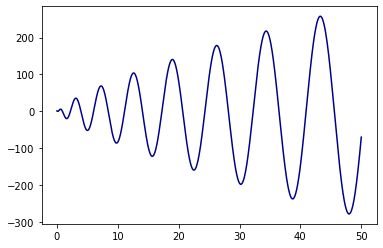

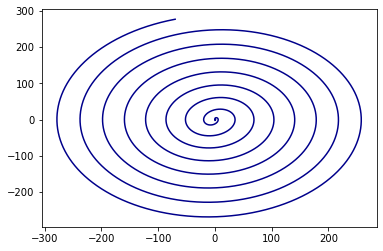

In [27]:
fig, ax = plt.subplots(1, 1)
plt.plot(np.linspace(0, T, num = len(u_)), u_[:, 0], color = 'darkblue')
plt.show()

fig, ax = plt.subplots(1, 1)
plt.plot(u_[:, 0], u_[:, 1], color = 'darkblue')
plt.show()